# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

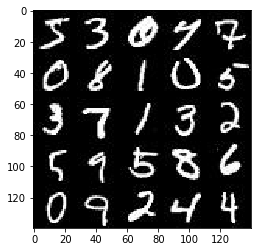

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

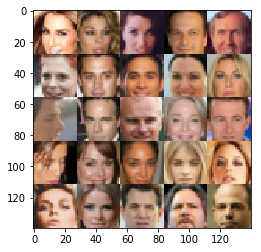

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


/Users/two/anaconda/envs/tflearn/lib/python3.5/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [97]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    input_z = tf.placeholder(tf.float32, [None, z_dim], name="input_z")
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [99]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    # Input images is 28x28
    with tf.variable_scope('discriminator', reuse=reuse):
        # 14x14x64 filters, skip batch normalization on first layer
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        # 7x7x128 filters
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        # 4x4x256 filters
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        # Flatten image
        flat_image = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat_image, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [105]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=not is_train):
        # 7x7x512
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        # 14x14x256
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        # 14x14x128
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=1, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        # 28x28x3
        logits = tf.tanh(tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same'))
        
        return logits
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [119]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    generator_model = generator(input_z, out_channel_dim)

    discriminator_model_real, discriminator_logits_real = discriminator(input_real)
    discriminator_model_fake, discriminator_logits_fake = discriminator(generator_model, reuse=True)

    discriminator_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_real, labels=tf.ones_like(discriminator_model_real)))
    discriminator_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_fake, labels=tf.zeros_like(discriminator_model_fake)))
    
    generator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_fake, labels=tf.ones_like(discriminator_model_fake)))

    discriminator_loss = discriminator_loss_real + discriminator_loss_fake

    return discriminator_loss, generator_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [110]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [111]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [126]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Build Model
    # Build Model
    width = data_shape[1]
    height = data_shape[2]
    channels = data_shape[3]
    
    images, dimensions, lr = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(images, dimensions, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    print_every = 10
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # Train Model
                steps += 1
                
                batch_images *= 2.0
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={images: batch_images, dimensions: batch_z})
                _ = sess.run(g_opt, feed_dict={images: batch_images, dimensions: batch_z})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({images: batch_images, dimensions: batch_z})
                    train_loss_g = g_loss.eval({dimensions: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, 25, dimensions, channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.2166... Generator Loss: 11.7277
Epoch 1/2... Discriminator Loss: 0.0103... Generator Loss: 10.6717
Epoch 1/2... Discriminator Loss: 0.0841... Generator Loss: 3.3542
Epoch 1/2... Discriminator Loss: 2.6101... Generator Loss: 0.2799
Epoch 1/2... Discriminator Loss: 0.7450... Generator Loss: 1.1141
Epoch 1/2... Discriminator Loss: 1.4968... Generator Loss: 2.3076
Epoch 1/2... Discriminator Loss: 0.9788... Generator Loss: 1.7013
Epoch 1/2... Discriminator Loss: 0.9577... Generator Loss: 1.2255
Epoch 1/2... Discriminator Loss: 1.2665... Generator Loss: 0.5326
Epoch 1/2... Discriminator Loss: 1.3615... Generator Loss: 0.8620


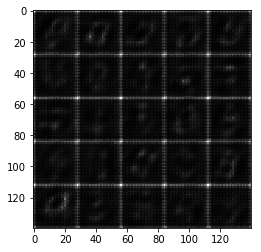

Epoch 1/2... Discriminator Loss: 2.0399... Generator Loss: 0.2000
Epoch 1/2... Discriminator Loss: 1.0781... Generator Loss: 0.9624
Epoch 1/2... Discriminator Loss: 1.1546... Generator Loss: 1.0109
Epoch 1/2... Discriminator Loss: 1.2476... Generator Loss: 0.8029
Epoch 1/2... Discriminator Loss: 1.3330... Generator Loss: 0.6230
Epoch 1/2... Discriminator Loss: 1.2605... Generator Loss: 0.6621
Epoch 1/2... Discriminator Loss: 1.2953... Generator Loss: 0.7112
Epoch 1/2... Discriminator Loss: 1.3583... Generator Loss: 1.1252
Epoch 1/2... Discriminator Loss: 1.1829... Generator Loss: 1.0117
Epoch 1/2... Discriminator Loss: 0.9078... Generator Loss: 1.3693


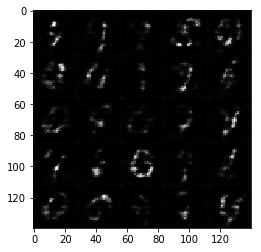

Epoch 1/2... Discriminator Loss: 1.0685... Generator Loss: 1.5411
Epoch 1/2... Discriminator Loss: 1.0119... Generator Loss: 1.3312
Epoch 1/2... Discriminator Loss: 1.0042... Generator Loss: 1.0491
Epoch 1/2... Discriminator Loss: 1.4423... Generator Loss: 0.4290
Epoch 1/2... Discriminator Loss: 1.0897... Generator Loss: 1.3972
Epoch 1/2... Discriminator Loss: 1.0650... Generator Loss: 0.6532
Epoch 1/2... Discriminator Loss: 1.0121... Generator Loss: 1.1947
Epoch 1/2... Discriminator Loss: 1.4507... Generator Loss: 0.4307
Epoch 1/2... Discriminator Loss: 1.5210... Generator Loss: 0.3294
Epoch 1/2... Discriminator Loss: 0.9783... Generator Loss: 1.2965


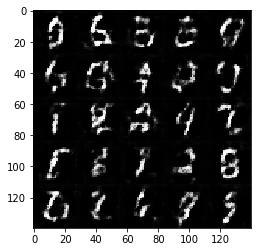

Epoch 1/2... Discriminator Loss: 1.0156... Generator Loss: 0.8298
Epoch 1/2... Discriminator Loss: 1.1459... Generator Loss: 0.8747
Epoch 1/2... Discriminator Loss: 1.0978... Generator Loss: 1.0871
Epoch 1/2... Discriminator Loss: 1.1274... Generator Loss: 0.6428
Epoch 1/2... Discriminator Loss: 0.9800... Generator Loss: 1.0948
Epoch 1/2... Discriminator Loss: 1.0934... Generator Loss: 0.9155
Epoch 1/2... Discriminator Loss: 1.0940... Generator Loss: 1.1441
Epoch 1/2... Discriminator Loss: 1.0034... Generator Loss: 0.8043
Epoch 1/2... Discriminator Loss: 1.0808... Generator Loss: 0.9212
Epoch 1/2... Discriminator Loss: 1.3742... Generator Loss: 0.5109


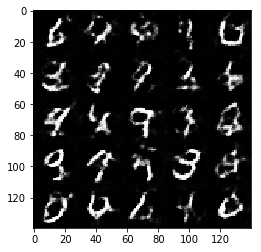

Epoch 1/2... Discriminator Loss: 0.9519... Generator Loss: 0.9694
Epoch 1/2... Discriminator Loss: 1.0334... Generator Loss: 0.8073
Epoch 1/2... Discriminator Loss: 1.1296... Generator Loss: 0.8556
Epoch 1/2... Discriminator Loss: 1.0590... Generator Loss: 0.8414
Epoch 1/2... Discriminator Loss: 0.9279... Generator Loss: 1.1088
Epoch 1/2... Discriminator Loss: 1.2308... Generator Loss: 1.1058
Epoch 1/2... Discriminator Loss: 1.1601... Generator Loss: 1.2771
Epoch 1/2... Discriminator Loss: 1.1449... Generator Loss: 0.8803
Epoch 1/2... Discriminator Loss: 1.2630... Generator Loss: 0.8931
Epoch 1/2... Discriminator Loss: 1.0889... Generator Loss: 0.6831


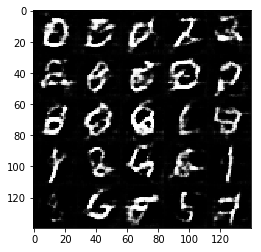

Epoch 1/2... Discriminator Loss: 1.2196... Generator Loss: 1.2035
Epoch 1/2... Discriminator Loss: 1.1254... Generator Loss: 0.6831
Epoch 1/2... Discriminator Loss: 1.0745... Generator Loss: 0.6870
Epoch 1/2... Discriminator Loss: 1.0285... Generator Loss: 0.9677
Epoch 1/2... Discriminator Loss: 1.0639... Generator Loss: 0.7436
Epoch 1/2... Discriminator Loss: 1.1251... Generator Loss: 0.9354
Epoch 1/2... Discriminator Loss: 1.4520... Generator Loss: 0.4389
Epoch 1/2... Discriminator Loss: 1.1954... Generator Loss: 0.5736
Epoch 1/2... Discriminator Loss: 1.1205... Generator Loss: 0.5588
Epoch 1/2... Discriminator Loss: 0.9201... Generator Loss: 1.0406


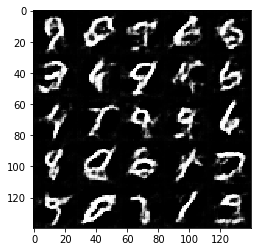

Epoch 1/2... Discriminator Loss: 1.0929... Generator Loss: 0.7912
Epoch 1/2... Discriminator Loss: 1.2687... Generator Loss: 0.5222
Epoch 1/2... Discriminator Loss: 0.9913... Generator Loss: 0.8408
Epoch 1/2... Discriminator Loss: 0.9813... Generator Loss: 1.3120
Epoch 1/2... Discriminator Loss: 1.2223... Generator Loss: 0.4999
Epoch 1/2... Discriminator Loss: 1.4830... Generator Loss: 0.4299
Epoch 1/2... Discriminator Loss: 1.5735... Generator Loss: 0.3198
Epoch 1/2... Discriminator Loss: 1.2428... Generator Loss: 0.5878
Epoch 1/2... Discriminator Loss: 0.9711... Generator Loss: 0.9342
Epoch 1/2... Discriminator Loss: 1.4849... Generator Loss: 2.5808


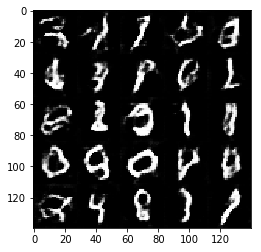

Epoch 1/2... Discriminator Loss: 1.0873... Generator Loss: 0.8946
Epoch 1/2... Discriminator Loss: 1.0130... Generator Loss: 0.8515
Epoch 1/2... Discriminator Loss: 1.1419... Generator Loss: 0.5453
Epoch 1/2... Discriminator Loss: 2.6162... Generator Loss: 3.0638
Epoch 1/2... Discriminator Loss: 0.9380... Generator Loss: 0.8881
Epoch 1/2... Discriminator Loss: 1.0443... Generator Loss: 0.7081
Epoch 1/2... Discriminator Loss: 0.9473... Generator Loss: 0.6783
Epoch 1/2... Discriminator Loss: 1.3159... Generator Loss: 0.7659
Epoch 1/2... Discriminator Loss: 1.2297... Generator Loss: 0.5504
Epoch 1/2... Discriminator Loss: 1.0816... Generator Loss: 0.8479


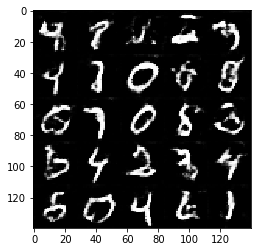

Epoch 1/2... Discriminator Loss: 0.9983... Generator Loss: 0.9116
Epoch 1/2... Discriminator Loss: 1.1010... Generator Loss: 0.6829
Epoch 1/2... Discriminator Loss: 0.9987... Generator Loss: 1.4297
Epoch 1/2... Discriminator Loss: 0.8081... Generator Loss: 1.1407
Epoch 1/2... Discriminator Loss: 0.7618... Generator Loss: 1.2342
Epoch 1/2... Discriminator Loss: 2.2665... Generator Loss: 0.2036
Epoch 1/2... Discriminator Loss: 1.1195... Generator Loss: 1.1301
Epoch 1/2... Discriminator Loss: 1.0925... Generator Loss: 0.6719
Epoch 1/2... Discriminator Loss: 0.7851... Generator Loss: 1.2264
Epoch 1/2... Discriminator Loss: 0.9851... Generator Loss: 1.0605


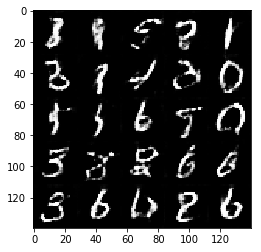

Epoch 1/2... Discriminator Loss: 1.2825... Generator Loss: 0.4501
Epoch 1/2... Discriminator Loss: 0.7654... Generator Loss: 1.1326
Epoch 1/2... Discriminator Loss: 1.1687... Generator Loss: 0.6355
Epoch 2/2... Discriminator Loss: 1.3014... Generator Loss: 0.4298
Epoch 2/2... Discriminator Loss: 1.3817... Generator Loss: 0.6899
Epoch 2/2... Discriminator Loss: 1.0601... Generator Loss: 0.8848
Epoch 2/2... Discriminator Loss: 1.1231... Generator Loss: 0.7144
Epoch 2/2... Discriminator Loss: 1.1513... Generator Loss: 0.6517
Epoch 2/2... Discriminator Loss: 1.2005... Generator Loss: 1.0792
Epoch 2/2... Discriminator Loss: 0.9518... Generator Loss: 1.1126


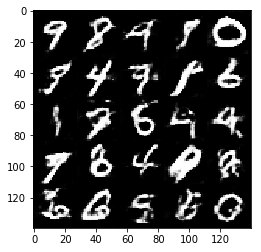

Epoch 2/2... Discriminator Loss: 0.9299... Generator Loss: 0.8260
Epoch 2/2... Discriminator Loss: 0.9782... Generator Loss: 0.7474
Epoch 2/2... Discriminator Loss: 0.9611... Generator Loss: 0.7688
Epoch 2/2... Discriminator Loss: 0.9266... Generator Loss: 1.0643
Epoch 2/2... Discriminator Loss: 0.8240... Generator Loss: 1.0101
Epoch 2/2... Discriminator Loss: 1.2044... Generator Loss: 0.4974
Epoch 2/2... Discriminator Loss: 2.6269... Generator Loss: 0.1009
Epoch 2/2... Discriminator Loss: 1.0310... Generator Loss: 0.6931
Epoch 2/2... Discriminator Loss: 1.1549... Generator Loss: 0.5233
Epoch 2/2... Discriminator Loss: 1.0939... Generator Loss: 0.6066


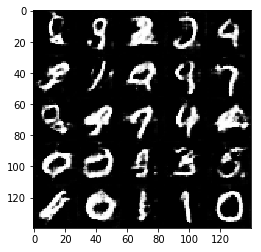

Epoch 2/2... Discriminator Loss: 0.6612... Generator Loss: 1.4552
Epoch 2/2... Discriminator Loss: 1.3495... Generator Loss: 0.4881
Epoch 2/2... Discriminator Loss: 0.7508... Generator Loss: 1.2637
Epoch 2/2... Discriminator Loss: 1.1682... Generator Loss: 0.5449
Epoch 2/2... Discriminator Loss: 0.9267... Generator Loss: 0.9773
Epoch 2/2... Discriminator Loss: 0.9075... Generator Loss: 1.0081
Epoch 2/2... Discriminator Loss: 1.1204... Generator Loss: 0.5852
Epoch 2/2... Discriminator Loss: 0.8462... Generator Loss: 0.8327
Epoch 2/2... Discriminator Loss: 0.9240... Generator Loss: 1.7332
Epoch 2/2... Discriminator Loss: 0.8004... Generator Loss: 0.9052


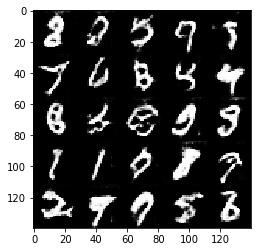

Epoch 2/2... Discriminator Loss: 0.6816... Generator Loss: 1.3293
Epoch 2/2... Discriminator Loss: 2.7769... Generator Loss: 3.6985
Epoch 2/2... Discriminator Loss: 1.2090... Generator Loss: 0.5600
Epoch 2/2... Discriminator Loss: 1.0692... Generator Loss: 0.6351
Epoch 2/2... Discriminator Loss: 1.0815... Generator Loss: 0.6419
Epoch 2/2... Discriminator Loss: 1.1505... Generator Loss: 0.6778
Epoch 2/2... Discriminator Loss: 1.4151... Generator Loss: 0.4193
Epoch 2/2... Discriminator Loss: 1.0767... Generator Loss: 0.6143
Epoch 2/2... Discriminator Loss: 0.8442... Generator Loss: 1.2673
Epoch 2/2... Discriminator Loss: 0.8121... Generator Loss: 1.7205


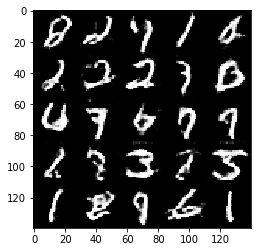

Epoch 2/2... Discriminator Loss: 0.7672... Generator Loss: 1.4294
Epoch 2/2... Discriminator Loss: 1.3238... Generator Loss: 1.8650
Epoch 2/2... Discriminator Loss: 0.7507... Generator Loss: 1.7324
Epoch 2/2... Discriminator Loss: 0.6849... Generator Loss: 1.3330
Epoch 2/2... Discriminator Loss: 1.1467... Generator Loss: 0.5639
Epoch 2/2... Discriminator Loss: 0.9490... Generator Loss: 0.7264
Epoch 2/2... Discriminator Loss: 2.3474... Generator Loss: 0.2754
Epoch 2/2... Discriminator Loss: 0.7200... Generator Loss: 1.3820
Epoch 2/2... Discriminator Loss: 0.9354... Generator Loss: 0.7712
Epoch 2/2... Discriminator Loss: 1.1857... Generator Loss: 2.7318


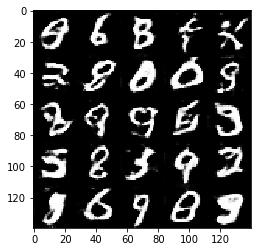

Epoch 2/2... Discriminator Loss: 1.2419... Generator Loss: 0.5490
Epoch 2/2... Discriminator Loss: 0.9631... Generator Loss: 0.9709
Epoch 2/2... Discriminator Loss: 1.0959... Generator Loss: 0.6260
Epoch 2/2... Discriminator Loss: 0.9751... Generator Loss: 0.6717
Epoch 2/2... Discriminator Loss: 2.4205... Generator Loss: 0.1950
Epoch 2/2... Discriminator Loss: 1.1757... Generator Loss: 0.5418
Epoch 2/2... Discriminator Loss: 0.9460... Generator Loss: 0.7320
Epoch 2/2... Discriminator Loss: 0.8367... Generator Loss: 0.8139
Epoch 2/2... Discriminator Loss: 1.1472... Generator Loss: 0.5520
Epoch 2/2... Discriminator Loss: 0.6494... Generator Loss: 1.0972


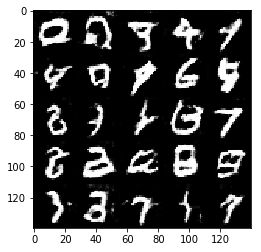

Epoch 2/2... Discriminator Loss: 0.9818... Generator Loss: 0.6550
Epoch 2/2... Discriminator Loss: 0.5936... Generator Loss: 1.1997
Epoch 2/2... Discriminator Loss: 0.6868... Generator Loss: 1.6052
Epoch 2/2... Discriminator Loss: 1.0162... Generator Loss: 0.7486
Epoch 2/2... Discriminator Loss: 0.9179... Generator Loss: 0.7371
Epoch 2/2... Discriminator Loss: 1.1538... Generator Loss: 0.5337
Epoch 2/2... Discriminator Loss: 1.1069... Generator Loss: 0.5538
Epoch 2/2... Discriminator Loss: 0.6150... Generator Loss: 1.1591
Epoch 2/2... Discriminator Loss: 0.9947... Generator Loss: 1.1654
Epoch 2/2... Discriminator Loss: 0.7215... Generator Loss: 1.6540


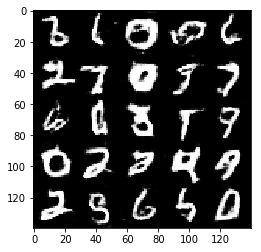

Epoch 2/2... Discriminator Loss: 0.7487... Generator Loss: 0.9758
Epoch 2/2... Discriminator Loss: 1.5840... Generator Loss: 3.3449
Epoch 2/2... Discriminator Loss: 0.8545... Generator Loss: 0.7980
Epoch 2/2... Discriminator Loss: 0.7791... Generator Loss: 1.0773
Epoch 2/2... Discriminator Loss: 1.0302... Generator Loss: 0.6035
Epoch 2/2... Discriminator Loss: 0.5375... Generator Loss: 1.2076
Epoch 2/2... Discriminator Loss: 1.1549... Generator Loss: 0.5403
Epoch 2/2... Discriminator Loss: 1.5947... Generator Loss: 0.3293
Epoch 2/2... Discriminator Loss: 1.3052... Generator Loss: 0.5109
Epoch 2/2... Discriminator Loss: 0.9873... Generator Loss: 0.6582


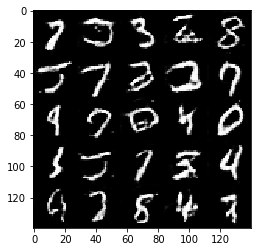

Epoch 2/2... Discriminator Loss: 1.8789... Generator Loss: 0.2663
Epoch 2/2... Discriminator Loss: 1.0404... Generator Loss: 0.5612
Epoch 2/2... Discriminator Loss: 0.9384... Generator Loss: 0.7098
Epoch 2/2... Discriminator Loss: 0.7457... Generator Loss: 1.3144
Epoch 2/2... Discriminator Loss: 0.6762... Generator Loss: 1.3376
Epoch 2/2... Discriminator Loss: 0.4784... Generator Loss: 1.4229
Epoch 2/2... Discriminator Loss: 0.6261... Generator Loss: 1.0746
Epoch 2/2... Discriminator Loss: 0.5511... Generator Loss: 1.6504
Epoch 2/2... Discriminator Loss: 0.7072... Generator Loss: 3.2608
Epoch 2/2... Discriminator Loss: 0.7182... Generator Loss: 1.3323


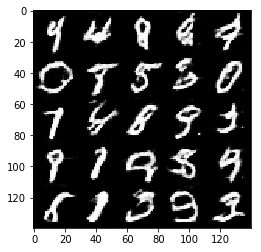

Epoch 2/2... Discriminator Loss: 0.7863... Generator Loss: 1.1339
Epoch 2/2... Discriminator Loss: 1.0997... Generator Loss: 0.6593
Epoch 2/2... Discriminator Loss: 1.0305... Generator Loss: 0.6262
Epoch 2/2... Discriminator Loss: 0.7967... Generator Loss: 1.0139
Epoch 2/2... Discriminator Loss: 1.0972... Generator Loss: 2.5356
Epoch 2/2... Discriminator Loss: 0.7152... Generator Loss: 1.1859
Epoch 2/2... Discriminator Loss: 0.7790... Generator Loss: 0.9600


In [128]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.9529... Generator Loss: 0.1961
Epoch 1/1... Discriminator Loss: 0.7437... Generator Loss: 1.6527
Epoch 1/1... Discriminator Loss: 1.7424... Generator Loss: 0.4744
Epoch 1/1... Discriminator Loss: 3.3608... Generator Loss: 0.0723
Epoch 1/1... Discriminator Loss: 1.9646... Generator Loss: 0.2659
Epoch 1/1... Discriminator Loss: 1.6414... Generator Loss: 2.1120
Epoch 1/1... Discriminator Loss: 1.6560... Generator Loss: 0.3715
Epoch 1/1... Discriminator Loss: 1.6604... Generator Loss: 0.6230
Epoch 1/1... Discriminator Loss: 2.0130... Generator Loss: 0.4847
Epoch 1/1... Discriminator Loss: 1.9506... Generator Loss: 0.3416


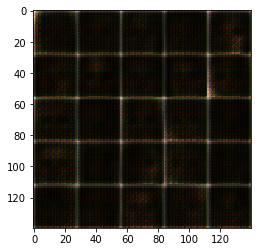

Epoch 1/1... Discriminator Loss: 1.7071... Generator Loss: 0.3517
Epoch 1/1... Discriminator Loss: 1.7961... Generator Loss: 0.5089
Epoch 1/1... Discriminator Loss: 1.7201... Generator Loss: 0.5835
Epoch 1/1... Discriminator Loss: 1.6526... Generator Loss: 0.6014
Epoch 1/1... Discriminator Loss: 1.4356... Generator Loss: 0.5374
Epoch 1/1... Discriminator Loss: 1.0171... Generator Loss: 0.7859
Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.6017
Epoch 1/1... Discriminator Loss: 1.4851... Generator Loss: 0.6602
Epoch 1/1... Discriminator Loss: 1.5632... Generator Loss: 2.4663
Epoch 1/1... Discriminator Loss: 1.1155... Generator Loss: 0.7009


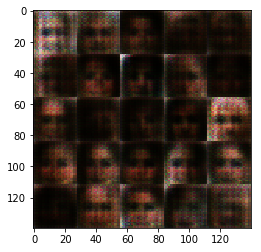

Epoch 1/1... Discriminator Loss: 2.5087... Generator Loss: 0.1349
Epoch 1/1... Discriminator Loss: 1.2600... Generator Loss: 0.7959
Epoch 1/1... Discriminator Loss: 0.9074... Generator Loss: 0.8794
Epoch 1/1... Discriminator Loss: 1.4769... Generator Loss: 0.4841
Epoch 1/1... Discriminator Loss: 1.1542... Generator Loss: 0.7549
Epoch 1/1... Discriminator Loss: 1.5934... Generator Loss: 0.6026
Epoch 1/1... Discriminator Loss: 1.5977... Generator Loss: 0.4966
Epoch 1/1... Discriminator Loss: 1.5351... Generator Loss: 0.6243
Epoch 1/1... Discriminator Loss: 1.4788... Generator Loss: 0.6721
Epoch 1/1... Discriminator Loss: 1.6703... Generator Loss: 0.6686


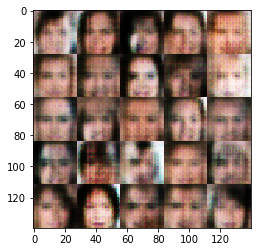

Epoch 1/1... Discriminator Loss: 1.6011... Generator Loss: 0.5802
Epoch 1/1... Discriminator Loss: 0.9881... Generator Loss: 1.1064
Epoch 1/1... Discriminator Loss: 1.5051... Generator Loss: 0.4341
Epoch 1/1... Discriminator Loss: 1.2572... Generator Loss: 0.6829
Epoch 1/1... Discriminator Loss: 0.9871... Generator Loss: 1.8412
Epoch 1/1... Discriminator Loss: 1.6667... Generator Loss: 0.3708
Epoch 1/1... Discriminator Loss: 1.3573... Generator Loss: 0.7283
Epoch 1/1... Discriminator Loss: 1.4057... Generator Loss: 0.5496
Epoch 1/1... Discriminator Loss: 1.8381... Generator Loss: 0.2442
Epoch 1/1... Discriminator Loss: 1.4820... Generator Loss: 1.1174


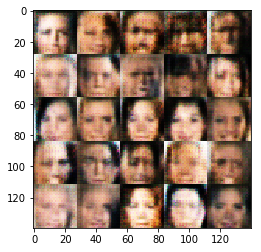

Epoch 1/1... Discriminator Loss: 1.1361... Generator Loss: 0.7312
Epoch 1/1... Discriminator Loss: 1.3296... Generator Loss: 0.7016
Epoch 1/1... Discriminator Loss: 1.2091... Generator Loss: 0.9065
Epoch 1/1... Discriminator Loss: 1.3293... Generator Loss: 0.8622
Epoch 1/1... Discriminator Loss: 1.2068... Generator Loss: 0.7544
Epoch 1/1... Discriminator Loss: 1.1756... Generator Loss: 0.9827
Epoch 1/1... Discriminator Loss: 0.9025... Generator Loss: 1.0547
Epoch 1/1... Discriminator Loss: 1.7367... Generator Loss: 0.3368
Epoch 1/1... Discriminator Loss: 1.2959... Generator Loss: 0.9557
Epoch 1/1... Discriminator Loss: 1.0491... Generator Loss: 1.3374


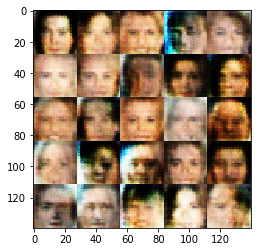

Epoch 1/1... Discriminator Loss: 1.3850... Generator Loss: 0.5142
Epoch 1/1... Discriminator Loss: 0.9050... Generator Loss: 1.0531
Epoch 1/1... Discriminator Loss: 1.0211... Generator Loss: 1.3848
Epoch 1/1... Discriminator Loss: 1.4436... Generator Loss: 1.2356
Epoch 1/1... Discriminator Loss: 1.1043... Generator Loss: 0.5964
Epoch 1/1... Discriminator Loss: 1.2860... Generator Loss: 0.5656
Epoch 1/1... Discriminator Loss: 1.0119... Generator Loss: 1.1851
Epoch 1/1... Discriminator Loss: 1.0457... Generator Loss: 0.9283
Epoch 1/1... Discriminator Loss: 1.0513... Generator Loss: 1.9131
Epoch 1/1... Discriminator Loss: 0.9231... Generator Loss: 1.3964


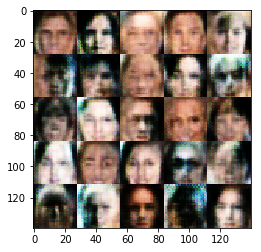

Epoch 1/1... Discriminator Loss: 0.9775... Generator Loss: 1.7093
Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.6703
Epoch 1/1... Discriminator Loss: 1.5552... Generator Loss: 0.3620
Epoch 1/1... Discriminator Loss: 1.1140... Generator Loss: 1.6163
Epoch 1/1... Discriminator Loss: 0.9955... Generator Loss: 2.0216
Epoch 1/1... Discriminator Loss: 0.6685... Generator Loss: 1.8301
Epoch 1/1... Discriminator Loss: 1.1066... Generator Loss: 1.2341
Epoch 1/1... Discriminator Loss: 0.9301... Generator Loss: 1.9737
Epoch 1/1... Discriminator Loss: 0.5918... Generator Loss: 1.4166
Epoch 1/1... Discriminator Loss: 1.2711... Generator Loss: 0.5133


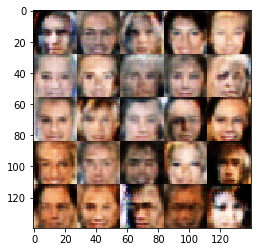

Epoch 1/1... Discriminator Loss: 1.1012... Generator Loss: 1.6704
Epoch 1/1... Discriminator Loss: 1.1029... Generator Loss: 1.2952
Epoch 1/1... Discriminator Loss: 1.0253... Generator Loss: 0.7397
Epoch 1/1... Discriminator Loss: 1.2728... Generator Loss: 0.4662
Epoch 1/1... Discriminator Loss: 1.4624... Generator Loss: 0.4110
Epoch 1/1... Discriminator Loss: 1.1800... Generator Loss: 0.6995
Epoch 1/1... Discriminator Loss: 0.4276... Generator Loss: 1.4998
Epoch 1/1... Discriminator Loss: 0.8586... Generator Loss: 1.6453
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.4613
Epoch 1/1... Discriminator Loss: 1.2683... Generator Loss: 0.4390


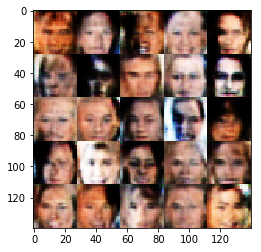

Epoch 1/1... Discriminator Loss: 0.9152... Generator Loss: 1.3042
Epoch 1/1... Discriminator Loss: 1.5280... Generator Loss: 0.3361
Epoch 1/1... Discriminator Loss: 0.9891... Generator Loss: 0.8187
Epoch 1/1... Discriminator Loss: 0.5341... Generator Loss: 1.6170
Epoch 1/1... Discriminator Loss: 1.2079... Generator Loss: 0.5962
Epoch 1/1... Discriminator Loss: 1.0938... Generator Loss: 0.5482
Epoch 1/1... Discriminator Loss: 0.6713... Generator Loss: 2.1080
Epoch 1/1... Discriminator Loss: 1.0406... Generator Loss: 2.4631
Epoch 1/1... Discriminator Loss: 1.7542... Generator Loss: 0.2357
Epoch 1/1... Discriminator Loss: 1.6489... Generator Loss: 0.9006


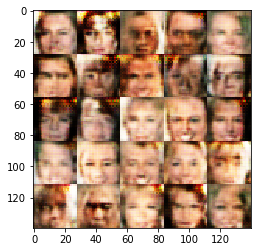

Epoch 1/1... Discriminator Loss: 0.9472... Generator Loss: 1.3364
Epoch 1/1... Discriminator Loss: 1.0548... Generator Loss: 0.9564
Epoch 1/1... Discriminator Loss: 1.1778... Generator Loss: 1.7739
Epoch 1/1... Discriminator Loss: 0.5885... Generator Loss: 1.6782
Epoch 1/1... Discriminator Loss: 1.8218... Generator Loss: 0.2293
Epoch 1/1... Discriminator Loss: 1.0559... Generator Loss: 0.7403
Epoch 1/1... Discriminator Loss: 0.8151... Generator Loss: 1.1729
Epoch 1/1... Discriminator Loss: 0.7908... Generator Loss: 0.7905
Epoch 1/1... Discriminator Loss: 1.2174... Generator Loss: 0.5881
Epoch 1/1... Discriminator Loss: 0.6938... Generator Loss: 1.0157


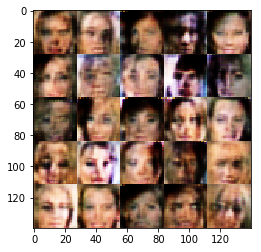

Epoch 1/1... Discriminator Loss: 0.7884... Generator Loss: 1.7948
Epoch 1/1... Discriminator Loss: 0.7272... Generator Loss: 1.1098
Epoch 1/1... Discriminator Loss: 0.9667... Generator Loss: 2.6276
Epoch 1/1... Discriminator Loss: 0.5390... Generator Loss: 3.0096
Epoch 1/1... Discriminator Loss: 1.0501... Generator Loss: 0.7527
Epoch 1/1... Discriminator Loss: 0.8272... Generator Loss: 0.9731
Epoch 1/1... Discriminator Loss: 0.6942... Generator Loss: 1.4870
Epoch 1/1... Discriminator Loss: 1.0739... Generator Loss: 0.7189
Epoch 1/1... Discriminator Loss: 1.4195... Generator Loss: 0.4788
Epoch 1/1... Discriminator Loss: 0.9250... Generator Loss: 1.4711


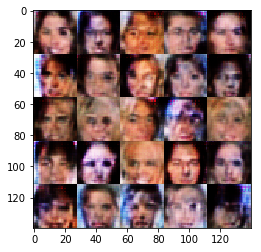

Epoch 1/1... Discriminator Loss: 0.9642... Generator Loss: 0.6878
Epoch 1/1... Discriminator Loss: 1.5359... Generator Loss: 0.3235
Epoch 1/1... Discriminator Loss: 1.1106... Generator Loss: 0.6011
Epoch 1/1... Discriminator Loss: 0.6846... Generator Loss: 1.3756
Epoch 1/1... Discriminator Loss: 1.7478... Generator Loss: 4.1751
Epoch 1/1... Discriminator Loss: 0.8209... Generator Loss: 0.9380
Epoch 1/1... Discriminator Loss: 2.0948... Generator Loss: 4.1786
Epoch 1/1... Discriminator Loss: 0.5575... Generator Loss: 1.4173
Epoch 1/1... Discriminator Loss: 0.6520... Generator Loss: 1.2713
Epoch 1/1... Discriminator Loss: 1.2397... Generator Loss: 3.0931


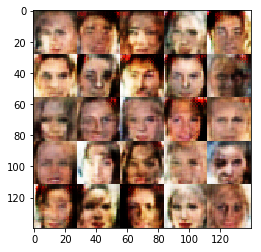

Epoch 1/1... Discriminator Loss: 0.7490... Generator Loss: 1.3700
Epoch 1/1... Discriminator Loss: 0.2757... Generator Loss: 2.3679
Epoch 1/1... Discriminator Loss: 0.6171... Generator Loss: 1.1838
Epoch 1/1... Discriminator Loss: 1.3897... Generator Loss: 0.4109
Epoch 1/1... Discriminator Loss: 1.0529... Generator Loss: 1.7184
Epoch 1/1... Discriminator Loss: 0.6395... Generator Loss: 1.4255
Epoch 1/1... Discriminator Loss: 0.7216... Generator Loss: 1.5283
Epoch 1/1... Discriminator Loss: 0.5205... Generator Loss: 1.7489
Epoch 1/1... Discriminator Loss: 0.8134... Generator Loss: 0.8892
Epoch 1/1... Discriminator Loss: 0.9037... Generator Loss: 0.6529


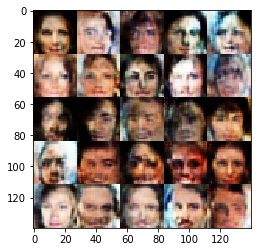

Epoch 1/1... Discriminator Loss: 0.6829... Generator Loss: 0.9455
Epoch 1/1... Discriminator Loss: 1.5908... Generator Loss: 0.5758
Epoch 1/1... Discriminator Loss: 1.2317... Generator Loss: 0.8244
Epoch 1/1... Discriminator Loss: 1.0103... Generator Loss: 0.6097
Epoch 1/1... Discriminator Loss: 1.6711... Generator Loss: 0.2882
Epoch 1/1... Discriminator Loss: 0.8714... Generator Loss: 0.8562
Epoch 1/1... Discriminator Loss: 0.8713... Generator Loss: 0.8786
Epoch 1/1... Discriminator Loss: 2.0976... Generator Loss: 2.1356
Epoch 1/1... Discriminator Loss: 1.9626... Generator Loss: 3.5426
Epoch 1/1... Discriminator Loss: 0.5750... Generator Loss: 1.2818


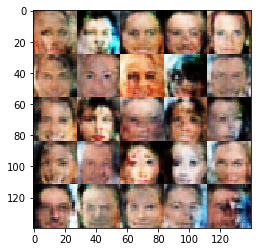

Epoch 1/1... Discriminator Loss: 1.0135... Generator Loss: 1.8913
Epoch 1/1... Discriminator Loss: 1.1581... Generator Loss: 2.5038
Epoch 1/1... Discriminator Loss: 1.3664... Generator Loss: 0.3892
Epoch 1/1... Discriminator Loss: 1.6848... Generator Loss: 0.2516
Epoch 1/1... Discriminator Loss: 0.7127... Generator Loss: 1.0742
Epoch 1/1... Discriminator Loss: 0.4990... Generator Loss: 2.4650
Epoch 1/1... Discriminator Loss: 0.8856... Generator Loss: 0.9082
Epoch 1/1... Discriminator Loss: 0.4040... Generator Loss: 2.2884
Epoch 1/1... Discriminator Loss: 1.8099... Generator Loss: 0.2474
Epoch 1/1... Discriminator Loss: 0.8610... Generator Loss: 0.8183


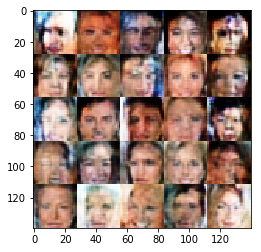

Epoch 1/1... Discriminator Loss: 0.8066... Generator Loss: 3.3307
Epoch 1/1... Discriminator Loss: 0.6846... Generator Loss: 0.9413
Epoch 1/1... Discriminator Loss: 0.6424... Generator Loss: 1.1348
Epoch 1/1... Discriminator Loss: 0.5313... Generator Loss: 1.2852
Epoch 1/1... Discriminator Loss: 1.5315... Generator Loss: 0.3251
Epoch 1/1... Discriminator Loss: 0.6260... Generator Loss: 3.3437
Epoch 1/1... Discriminator Loss: 0.9452... Generator Loss: 0.6311
Epoch 1/1... Discriminator Loss: 1.0131... Generator Loss: 2.9964
Epoch 1/1... Discriminator Loss: 1.9746... Generator Loss: 0.1725
Epoch 1/1... Discriminator Loss: 0.7464... Generator Loss: 1.9086


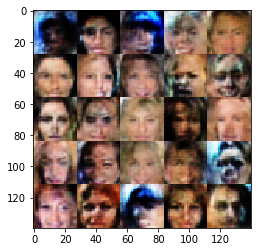

Epoch 1/1... Discriminator Loss: 1.7921... Generator Loss: 0.2547
Epoch 1/1... Discriminator Loss: 1.3140... Generator Loss: 0.4416
Epoch 1/1... Discriminator Loss: 0.6131... Generator Loss: 1.1944
Epoch 1/1... Discriminator Loss: 0.7040... Generator Loss: 1.1038
Epoch 1/1... Discriminator Loss: 0.6083... Generator Loss: 1.0375
Epoch 1/1... Discriminator Loss: 1.7764... Generator Loss: 3.0718
Epoch 1/1... Discriminator Loss: 0.4268... Generator Loss: 1.8472
Epoch 1/1... Discriminator Loss: 0.3173... Generator Loss: 4.0958
Epoch 1/1... Discriminator Loss: 1.3651... Generator Loss: 0.5482
Epoch 1/1... Discriminator Loss: 0.3375... Generator Loss: 3.0120


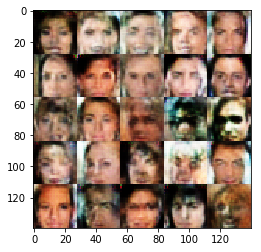

Epoch 1/1... Discriminator Loss: 0.4263... Generator Loss: 2.1617
Epoch 1/1... Discriminator Loss: 0.4354... Generator Loss: 1.9995
Epoch 1/1... Discriminator Loss: 0.7783... Generator Loss: 1.2270
Epoch 1/1... Discriminator Loss: 0.9197... Generator Loss: 1.4928
Epoch 1/1... Discriminator Loss: 0.5812... Generator Loss: 1.1202
Epoch 1/1... Discriminator Loss: 0.6890... Generator Loss: 1.9871
Epoch 1/1... Discriminator Loss: 0.5211... Generator Loss: 1.7605
Epoch 1/1... Discriminator Loss: 0.9378... Generator Loss: 0.7032
Epoch 1/1... Discriminator Loss: 1.0450... Generator Loss: 0.5803
Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.4981


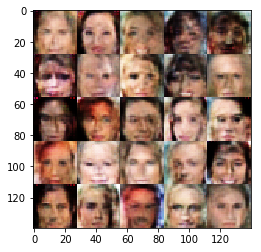

Epoch 1/1... Discriminator Loss: 1.2074... Generator Loss: 2.0806
Epoch 1/1... Discriminator Loss: 0.4018... Generator Loss: 1.8223
Epoch 1/1... Discriminator Loss: 0.3124... Generator Loss: 2.9419
Epoch 1/1... Discriminator Loss: 0.4070... Generator Loss: 1.6033
Epoch 1/1... Discriminator Loss: 0.4675... Generator Loss: 3.3900
Epoch 1/1... Discriminator Loss: 0.6381... Generator Loss: 0.9361
Epoch 1/1... Discriminator Loss: 1.1507... Generator Loss: 0.8121
Epoch 1/1... Discriminator Loss: 0.5441... Generator Loss: 1.1320
Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.3889
Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 2.6883


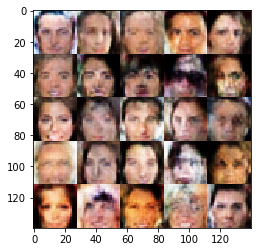

Epoch 1/1... Discriminator Loss: 0.6556... Generator Loss: 3.4035
Epoch 1/1... Discriminator Loss: 1.3370... Generator Loss: 0.3866
Epoch 1/1... Discriminator Loss: 0.8632... Generator Loss: 1.5808
Epoch 1/1... Discriminator Loss: 1.8286... Generator Loss: 0.2645
Epoch 1/1... Discriminator Loss: 0.4320... Generator Loss: 1.9079
Epoch 1/1... Discriminator Loss: 0.7352... Generator Loss: 0.9262
Epoch 1/1... Discriminator Loss: 0.8994... Generator Loss: 0.7098
Epoch 1/1... Discriminator Loss: 0.8167... Generator Loss: 2.4481
Epoch 1/1... Discriminator Loss: 0.4582... Generator Loss: 1.5876
Epoch 1/1... Discriminator Loss: 1.0753... Generator Loss: 1.6792


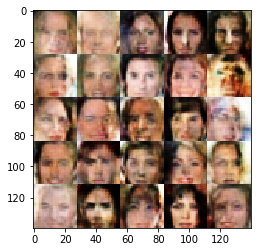

Epoch 1/1... Discriminator Loss: 0.4529... Generator Loss: 2.3841
Epoch 1/1... Discriminator Loss: 0.7286... Generator Loss: 3.4927
Epoch 1/1... Discriminator Loss: 0.5753... Generator Loss: 2.8876
Epoch 1/1... Discriminator Loss: 0.3058... Generator Loss: 2.3908
Epoch 1/1... Discriminator Loss: 2.6135... Generator Loss: 3.0790
Epoch 1/1... Discriminator Loss: 0.9305... Generator Loss: 3.2467
Epoch 1/1... Discriminator Loss: 0.7412... Generator Loss: 0.8508
Epoch 1/1... Discriminator Loss: 0.1023... Generator Loss: 3.8025
Epoch 1/1... Discriminator Loss: 0.4748... Generator Loss: 1.4357
Epoch 1/1... Discriminator Loss: 0.5997... Generator Loss: 1.1471


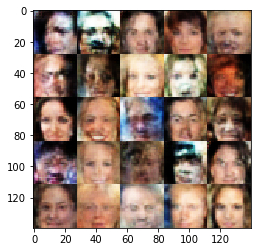

Epoch 1/1... Discriminator Loss: 0.2461... Generator Loss: 2.6609
Epoch 1/1... Discriminator Loss: 0.2407... Generator Loss: 2.2956
Epoch 1/1... Discriminator Loss: 0.7321... Generator Loss: 1.0356
Epoch 1/1... Discriminator Loss: 0.5833... Generator Loss: 1.1573
Epoch 1/1... Discriminator Loss: 1.6039... Generator Loss: 2.1592
Epoch 1/1... Discriminator Loss: 0.6303... Generator Loss: 1.2465
Epoch 1/1... Discriminator Loss: 0.5618... Generator Loss: 1.4045
Epoch 1/1... Discriminator Loss: 0.6848... Generator Loss: 3.0926
Epoch 1/1... Discriminator Loss: 0.5517... Generator Loss: 1.5640
Epoch 1/1... Discriminator Loss: 1.6574... Generator Loss: 2.0552


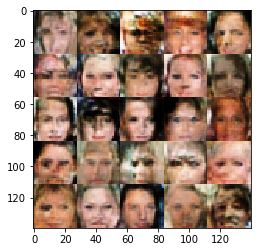

Epoch 1/1... Discriminator Loss: 0.8097... Generator Loss: 0.7898
Epoch 1/1... Discriminator Loss: 0.4498... Generator Loss: 1.3029
Epoch 1/1... Discriminator Loss: 2.3034... Generator Loss: 0.1478
Epoch 1/1... Discriminator Loss: 0.5845... Generator Loss: 1.8814
Epoch 1/1... Discriminator Loss: 0.3521... Generator Loss: 2.3069
Epoch 1/1... Discriminator Loss: 1.9522... Generator Loss: 0.2079
Epoch 1/1... Discriminator Loss: 0.4076... Generator Loss: 1.3520
Epoch 1/1... Discriminator Loss: 0.3477... Generator Loss: 2.5688
Epoch 1/1... Discriminator Loss: 0.4454... Generator Loss: 3.2978
Epoch 1/1... Discriminator Loss: 0.6458... Generator Loss: 1.5125


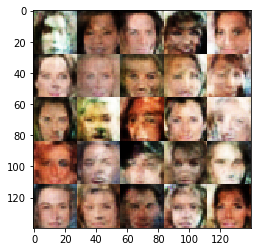

Epoch 1/1... Discriminator Loss: 0.2926... Generator Loss: 2.8430
Epoch 1/1... Discriminator Loss: 0.2977... Generator Loss: 3.2060
Epoch 1/1... Discriminator Loss: 1.2831... Generator Loss: 2.5320
Epoch 1/1... Discriminator Loss: 0.5184... Generator Loss: 2.8791
Epoch 1/1... Discriminator Loss: 1.0080... Generator Loss: 0.6363
Epoch 1/1... Discriminator Loss: 0.7310... Generator Loss: 2.3420
Epoch 1/1... Discriminator Loss: 3.2829... Generator Loss: 3.5106
Epoch 1/1... Discriminator Loss: 0.6381... Generator Loss: 1.0390
Epoch 1/1... Discriminator Loss: 0.4638... Generator Loss: 1.3076
Epoch 1/1... Discriminator Loss: 0.5560... Generator Loss: 1.0646


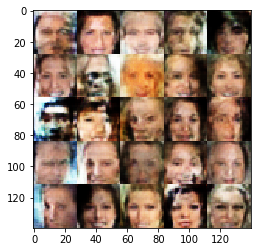

Epoch 1/1... Discriminator Loss: 0.3115... Generator Loss: 2.2705
Epoch 1/1... Discriminator Loss: 0.4697... Generator Loss: 1.2113
Epoch 1/1... Discriminator Loss: 0.7075... Generator Loss: 1.0760
Epoch 1/1... Discriminator Loss: 0.8007... Generator Loss: 4.2943
Epoch 1/1... Discriminator Loss: 0.4346... Generator Loss: 2.1530
Epoch 1/1... Discriminator Loss: 1.4202... Generator Loss: 0.3688
Epoch 1/1... Discriminator Loss: 0.2701... Generator Loss: 2.6465
Epoch 1/1... Discriminator Loss: 0.5464... Generator Loss: 2.7253
Epoch 1/1... Discriminator Loss: 0.2516... Generator Loss: 2.5416
Epoch 1/1... Discriminator Loss: 1.1151... Generator Loss: 0.5501


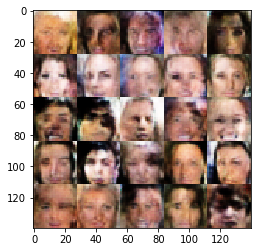

Epoch 1/1... Discriminator Loss: 0.3380... Generator Loss: 1.7106
Epoch 1/1... Discriminator Loss: 0.4049... Generator Loss: 1.6904
Epoch 1/1... Discriminator Loss: 1.2311... Generator Loss: 0.4440
Epoch 1/1... Discriminator Loss: 0.6896... Generator Loss: 1.0521
Epoch 1/1... Discriminator Loss: 1.5535... Generator Loss: 0.3319
Epoch 1/1... Discriminator Loss: 0.9953... Generator Loss: 2.6111
Epoch 1/1... Discriminator Loss: 0.9567... Generator Loss: 0.6395
Epoch 1/1... Discriminator Loss: 0.3592... Generator Loss: 1.9300
Epoch 1/1... Discriminator Loss: 0.3642... Generator Loss: 1.5581
Epoch 1/1... Discriminator Loss: 0.5793... Generator Loss: 1.1110


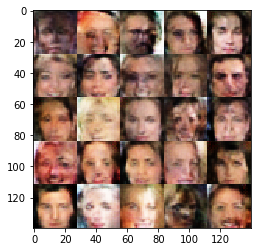

Epoch 1/1... Discriminator Loss: 0.9909... Generator Loss: 0.7236
Epoch 1/1... Discriminator Loss: 0.4101... Generator Loss: 3.2508
Epoch 1/1... Discriminator Loss: 0.2540... Generator Loss: 1.9987
Epoch 1/1... Discriminator Loss: 0.4101... Generator Loss: 1.4715
Epoch 1/1... Discriminator Loss: 0.2675... Generator Loss: 3.1556
Epoch 1/1... Discriminator Loss: 0.4798... Generator Loss: 4.2415
Epoch 1/1... Discriminator Loss: 2.5274... Generator Loss: 0.1186
Epoch 1/1... Discriminator Loss: 0.7770... Generator Loss: 0.8378
Epoch 1/1... Discriminator Loss: 1.5690... Generator Loss: 0.3297
Epoch 1/1... Discriminator Loss: 0.2052... Generator Loss: 2.3836


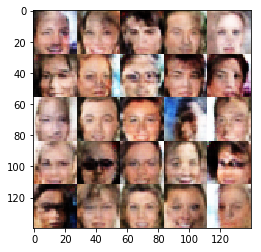

Epoch 1/1... Discriminator Loss: 0.4941... Generator Loss: 1.2089
Epoch 1/1... Discriminator Loss: 0.6227... Generator Loss: 1.0730
Epoch 1/1... Discriminator Loss: 0.6437... Generator Loss: 1.0690
Epoch 1/1... Discriminator Loss: 0.2834... Generator Loss: 3.2271
Epoch 1/1... Discriminator Loss: 1.0163... Generator Loss: 0.6272
Epoch 1/1... Discriminator Loss: 0.4818... Generator Loss: 1.6006
Epoch 1/1... Discriminator Loss: 1.2712... Generator Loss: 3.3433
Epoch 1/1... Discriminator Loss: 0.2424... Generator Loss: 3.6303
Epoch 1/1... Discriminator Loss: 1.0700... Generator Loss: 0.5654
Epoch 1/1... Discriminator Loss: 0.2421... Generator Loss: 2.1780


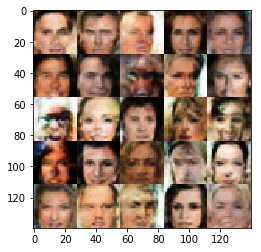

Epoch 1/1... Discriminator Loss: 0.3590... Generator Loss: 1.6925
Epoch 1/1... Discriminator Loss: 0.2579... Generator Loss: 2.1585
Epoch 1/1... Discriminator Loss: 0.2641... Generator Loss: 2.1239
Epoch 1/1... Discriminator Loss: 3.1547... Generator Loss: 0.0717
Epoch 1/1... Discriminator Loss: 1.6402... Generator Loss: 0.3290
Epoch 1/1... Discriminator Loss: 0.5461... Generator Loss: 1.2536
Epoch 1/1... Discriminator Loss: 2.1639... Generator Loss: 0.2543
Epoch 1/1... Discriminator Loss: 0.4902... Generator Loss: 2.0896
Epoch 1/1... Discriminator Loss: 0.5462... Generator Loss: 3.0054
Epoch 1/1... Discriminator Loss: 0.1777... Generator Loss: 2.8944


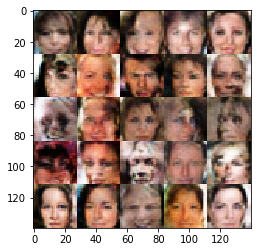

Epoch 1/1... Discriminator Loss: 0.2884... Generator Loss: 2.4717
Epoch 1/1... Discriminator Loss: 0.4878... Generator Loss: 1.7896
Epoch 1/1... Discriminator Loss: 0.4357... Generator Loss: 3.3902
Epoch 1/1... Discriminator Loss: 1.0613... Generator Loss: 2.7565
Epoch 1/1... Discriminator Loss: 1.2962... Generator Loss: 2.3746
Epoch 1/1... Discriminator Loss: 1.1036... Generator Loss: 3.1546
Epoch 1/1... Discriminator Loss: 0.6270... Generator Loss: 3.3574
Epoch 1/1... Discriminator Loss: 0.4423... Generator Loss: 1.3661
Epoch 1/1... Discriminator Loss: 0.3257... Generator Loss: 3.4468
Epoch 1/1... Discriminator Loss: 0.5291... Generator Loss: 1.1196


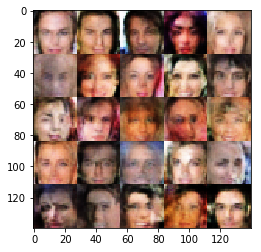

Epoch 1/1... Discriminator Loss: 0.7869... Generator Loss: 1.1859
Epoch 1/1... Discriminator Loss: 0.5038... Generator Loss: 2.0979
Epoch 1/1... Discriminator Loss: 1.1263... Generator Loss: 0.8950
Epoch 1/1... Discriminator Loss: 0.4534... Generator Loss: 2.9052
Epoch 1/1... Discriminator Loss: 0.5911... Generator Loss: 1.4366
Epoch 1/1... Discriminator Loss: 0.5237... Generator Loss: 3.4858
Epoch 1/1... Discriminator Loss: 0.4478... Generator Loss: 1.8180
Epoch 1/1... Discriminator Loss: 0.7921... Generator Loss: 2.1512
Epoch 1/1... Discriminator Loss: 0.3656... Generator Loss: 3.0029
Epoch 1/1... Discriminator Loss: 0.4585... Generator Loss: 1.3466


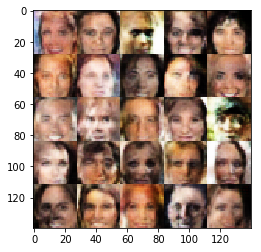

Epoch 1/1... Discriminator Loss: 0.4075... Generator Loss: 1.5813
Epoch 1/1... Discriminator Loss: 0.4077... Generator Loss: 2.0189
Epoch 1/1... Discriminator Loss: 0.2340... Generator Loss: 2.1350
Epoch 1/1... Discriminator Loss: 0.5618... Generator Loss: 1.9410
Epoch 1/1... Discriminator Loss: 0.2756... Generator Loss: 4.0493
Epoch 1/1... Discriminator Loss: 0.4446... Generator Loss: 1.3688


In [127]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.